In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Get Data

In [392]:
# Training
formation_start_date = datetime.fromisoformat('2021-01-01 00:00:00+00:00')
formation_end_date = datetime.fromisoformat('2021-01-14 00:00:00+00:00')
minimum_volume = 5000000
resolution = '15m'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices_df = pd.DataFrame(prices)
formation_prices_df = prices_df[formation_start_date:formation_end_date].T.dropna().T
formation_prices_df

Cannot find LDO-PERP data
Cannot find OP-PERP data


,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALT-PERP,ATOM-PERP,AVAX-PERP,BCH-PERP,BNB-PERP,BSV-PERP,...,TRX-PERP,UNI-PERP,USDT-PERP,VET-PERP,WAVES-PERP,XLM-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,ZEC-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.3172,85.97,0.178775,0.3335,1037.10,6.3005,3.235,337.55,37.0750,162.42,...,0.026502,5.008,1.0004,0.018570,6.1130,0.126975,0.216325,1.9867,22540.0,63.21
2021-01-01 00:15:00+00:00,1.3170,86.15,0.179005,0.3337,1035.15,6.2390,3.166,339.20,37.1125,162.80,...,0.026537,5.051,1.0005,0.018595,6.1240,0.126825,0.218975,1.9869,22540.0,63.54
2021-01-01 00:30:00+00:00,1.3323,86.71,0.180300,0.3395,1039.40,6.3155,3.144,340.95,37.2025,163.47,...,0.026652,5.142,1.0007,0.018730,6.1795,0.127725,0.220675,1.9946,22640.0,63.92
2021-01-01 00:45:00+00:00,1.3261,88.22,0.180705,0.3467,1044.25,6.4205,3.264,342.15,37.4525,163.45,...,0.026805,5.235,1.0008,0.019235,6.2835,0.128950,0.221425,2.0096,22875.0,64.78
2021-01-01 01:00:00+00:00,1.3137,88.16,0.181420,0.3438,1055.60,6.4475,3.240,346.05,37.6600,164.18,...,0.026992,5.272,1.0008,0.019820,6.2635,0.131000,0.223275,2.0259,22850.0,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13 23:00:00+00:00,1.2770,145.07,0.309595,0.4484,1409.20,6.2075,8.414,496.05,40.3125,210.99,...,0.030065,6.275,0.9999,0.026460,6.3580,0.303850,0.307075,2.4713,32765.0,118.21
2021-01-13 23:15:00+00:00,1.2826,144.30,0.314000,0.4512,1409.65,6.2035,8.457,496.05,40.3625,212.71,...,0.030197,6.289,0.9999,0.026220,6.3690,0.303925,0.306300,2.4770,32760.0,118.87
2021-01-13 23:30:00+00:00,1.2642,146.64,0.311200,0.4495,1402.70,6.1610,8.410,493.95,40.1200,211.53,...,0.030087,6.289,0.9999,0.026080,6.3645,0.302225,0.305450,2.4790,33235.0,116.97


#### Functions

In [412]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    positions = [0]
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(1, len(df)):
        if i == len(df) - 1 and current_pos == 0:
            pass
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
        elif current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1, 'spread': df.iloc[i]})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1, 'spread': df.iloc[i]})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        
        positions.append(current_pos)
    
    return (pd.DataFrame(trades), positions)

#### Narrow down coin universe

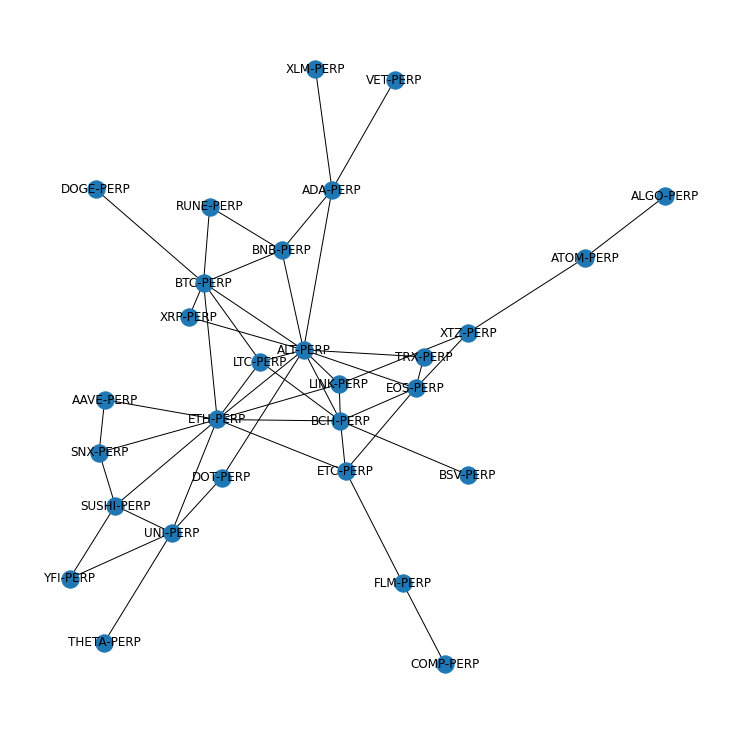

In [396]:
returns = formation_prices_df.pct_change()[1:]

edge_model = covariance.GraphicalLassoCV()
returns /= returns.std(axis=0)
edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=formation_prices_df.columns, index=formation_prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

#### Identify best pair candidates

In [397]:
# Find most mean reverting pairs
ridge = RidgeCV()
unique_pairs = []
possible_pairs = []
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_a, perp_b)
            if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                
                # regress prices
                ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))

                # test for mean-reversion
                spread =  formation_prices_df[perp_b] - ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                # calculate positions ratio in dollars
                total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                size_ratio = formation_prices_df[perp_b] / total_size

                possible_pairs.append({
                    'pair': pair,
                    'perp_a': perp_a,
                    'perp_b': perp_b,
                    'beta_units': ridge_reg.coef_[0][0],
                    'half_life': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst,
                    'long_short_position_ratio': size_ratio.mean()
                })

                unique_pairs.append(pair)

possible_pairs = pd.DataFrame(possible_pairs)
top_10_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['half_life'])[:10]
top_10_pairs

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
237,XTZ-PERP/LINK-PERP,XTZ-PERP,LINK-PERP,7.470586,13.664266,6.282768e-07,0.253759,0.452407
15,LTC-PERP/BNB-PERP,LTC-PERP,BNB-PERP,0.124643,14.174407,7.640374e-06,0.284455,0.681157
109,XRP-PERP/YFI-PERP,XRP-PERP,YFI-PERP,119460.371131,17.048479,1.498524e-05,0.312987,0.462092
299,LINK-PERP/ALT-PERP,LINK-PERP,ALT-PERP,85.209808,17.061723,2.043764e-04,0.356205,0.511859
103,AAVE-PERP/SNX-PERP,AAVE-PERP,SNX-PERP,0.141634,18.387463,2.732690e-04,0.291559,0.423883
251,XTZ-PERP/ALT-PERP,XTZ-PERP,ALT-PERP,642.836644,19.719993,3.453920e-04,0.290224,0.461746
246,XTZ-PERP/FLM-PERP,XTZ-PERP,FLM-PERP,0.048060,20.179438,3.704492e-04,0.270794,0.559982
54,UNI-PERP/VET-PERP,UNI-PERP,VET-PERP,0.005918,21.299794,4.714909e-04,0.309205,0.427489
378,BCH-PERP/FLM-PERP,BCH-PERP,FLM-PERP,0.000163,22.051955,2.213665e-04,0.314738,0.668107
58,DOT-PERP/RUNE-PERP,DOT-PERP,RUNE-PERP,0.154079,23.185428,5.815098e-05,0.343310,0.502013


### Backtest

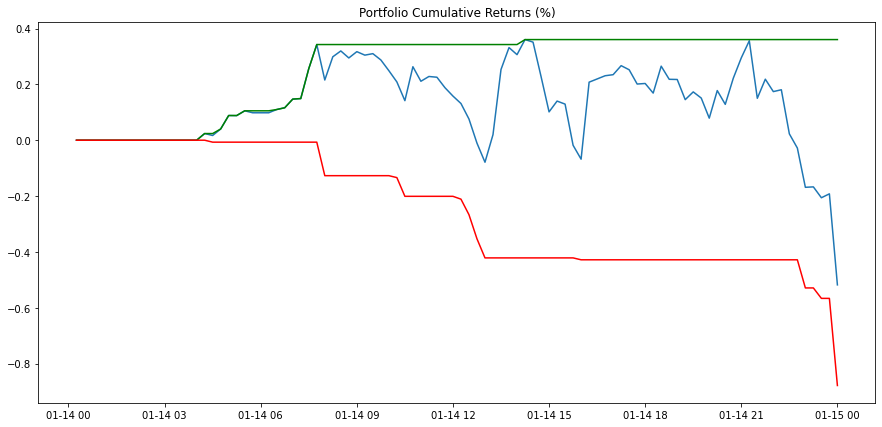

In [417]:
# all pairs together
trading_period_hours = 24*1
taker_fee = 0.0007
std_entry_multiple = 1.5
std_stop_multiple = 2.5
half_life_multiple = 1

trading_start_date = formation_end_date
trading_end_date = trading_start_date + timedelta(hours=trading_period_hours)
trading_prices_df = pd.DataFrame(prices)[trading_start_date:trading_end_date].T.dropna().T

trading_data = {}
portfolio_cumret = None
for i in range(0, len(top_10_pairs)):
    row = top_10_pairs.iloc[i]
    formation_spread = (formation_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
    formation_mean = formation_spread.mean()
    formation_std = formation_spread.std()

    # trades
    trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
    rolling_size_dollars = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]).sum(axis=1))
    rolling_mean = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.mean)
    rolling_std = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.std)
    rolling_entry = std_entry_multiple * rolling_std
    rolling_stop = std_stop_multiple * rolling_std
    trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

    if len(trades) > 0:
        # returns
        trades_fee = ((trading_prices_df.loc[trades['date'], [row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]) * taker_fee).sum(axis=1) # fee cost based on 2 trades per entry/close, matching size of 1 unit of b and its equivalent of a
        pnl = trading_spread.diff() * positions
        pnl_after_fees = pnl - trades_fee.reindex(pnl.index, fill_value=0)
        position_size = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1])).sum(axis=1)
        returns_after_fees = pnl_after_fees / position_size
        cumulative_returns = ((returns_after_fees + 1).cumprod() - 1)
        max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

        trading_data[row['pair']] = {
            'returns': cumulative_returns.iloc[-1],
            'max_drawdown': max_drawdown_returns.iloc[-1]
        }

        if portfolio_cumret is None:
            portfolio_cumret = cumulative_returns/len(top_10_pairs)
        else:
            portfolio_cumret += cumulative_returns/len(top_10_pairs)

    else:
        trading_data[row['pair']] = {
            'returns': 0,
            'max_drawdown': 0
        }
    
trading_data_df = pd.DataFrame(trading_data).T
trading_data_df['calmar_ratio'] = trading_data_df['returns'] / abs(trading_data_df['max_drawdown'])
trading_data_df

# we assume equal dollar size for each pair
portfolio_returns = trading_data_df['returns'].sum() / len(trading_data_df)
portfolio_max_dd = (portfolio_cumret - portfolio_cumret.cummax()).cummin()
portfolio_avg_calmar_ratio = trading_data_df['calmar_ratio'].mean()

plt.figure(figsize=(15,7))
plt.title('Portfolio Cumulative Returns (%)')
plt.plot(portfolio_cumret*100)
plt.plot(portfolio_cumret.cummax()*100, color='green')
plt.plot(portfolio_max_dd*100, color='red')


In [433]:
trading_data_df

,returns,max_drawdown,calmar_ratio
XTZ-PERP/LINK-PERP,-0.040723,-0.046325,-0.879064
LTC-PERP/BNB-PERP,-0.020286,-0.025767,-0.787304
XRP-PERP/YFI-PERP,0.017847,-0.009934,1.796550
LINK-PERP/ALT-PERP,-0.040120,-0.040381,-0.993534
AAVE-PERP/SNX-PERP,-0.013384,-0.034417,-0.388889
XTZ-PERP/ALT-PERP,-0.015550,-0.017511,-0.888046
XTZ-PERP/FLM-PERP,0.005985,-0.019987,0.299459
UNI-PERP/VET-PERP,0.000809,-0.012724,0.063580
BCH-PERP/FLM-PERP,0.018162,-0.007811,2.325040
DOT-PERP/RUNE-PERP,0.035436,-0.030101,1.177217


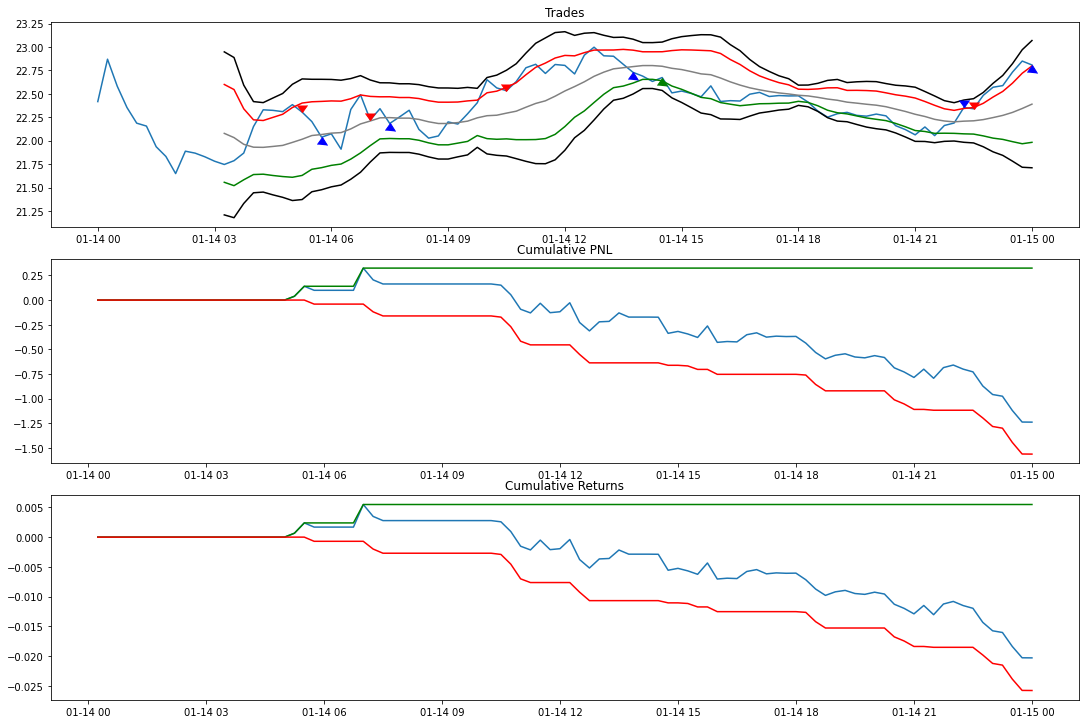

In [448]:
# Single pair example
row = top_10_pairs.iloc[1]
formation_spread = (formation_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
formation_mean = formation_spread.mean()
formation_std = formation_spread.std()

# trades
trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
position_size = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]).sum(axis=1))
rolling_mean = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.mean)
rolling_std = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.std)
rolling_entry = std_entry_multiple * rolling_std
rolling_stop = std_stop_multiple * rolling_std
trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

# put open and close on the same row
trades_formatted = []
for i in range(0, len(trades)):
    if trades.iloc[i]['position'] != 0:
        unit_position_size = position_size.loc[trades.iloc[i]['date']]
        fee = unit_position_size * taker_fee
        pnl = (trading_spread.loc[trades.iloc[i + 1]['date']] - trading_spread.loc[trades.iloc[i]['date']]) * trades.iloc[i]['position']
        pnl_after_fee = pnl - fee
        ret = pnl_after_fee / trading_spread.loc[trades.iloc[i]['date']]
        trades_formatted.append({
            'pair': row['pair'],
            'date_open': trades.iloc[i]['date'],
            'date_close': trades.iloc[i + 1]['date'],
            'position': trades.iloc[i]['position'],
            'price_a_open': trading_prices_df.loc[trades.iloc[i]['date']][row['perp_a']],
            'price_b_open': trading_prices_df.loc[trades.iloc[i]['date']][row['perp_b']],
            'price_a_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][row['perp_a']],
            'price_b_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][row['perp_b']],
            'spread_open': trading_spread.loc[trades.iloc[i]['date']],
            'spread_close': trading_spread.loc[trades.iloc[i+1]['date']],
            'beta': row['beta_units'],
            'one_unit_dollar_size': unit_position_size,
            'pnl': pnl,
            'fee': fee,
            'pnl_after_fee': pnl_after_fee,
            'return': ret,
            'duration': trades.iloc[i + 1]['date'] - trades.iloc[i]['date']
        })
trades_formatted = pd.DataFrame(trades_formatted)

if len(trades) > 0:
    # pnl
    trades_fee = ((trading_prices_df.loc[trades['date'], [row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]) * taker_fee).sum(axis=1) # fee cost based on 2 trades per entry/close, matching size of 1 unit of b and its equivalent of a
    pnl = trading_spread.diff() * positions
    pnl_after_fees = pnl - trades_fee.reindex(pnl.index, fill_value=0)
    cumulative_pnl = pnl_after_fees.cumsum()
    max_drawdown_pnl = (cumulative_pnl - cumulative_pnl.cummax()).cummin()

    # returns
    position_size = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1])).sum(axis=1)
    returns_after_fees = pnl_after_fees / position_size
    cumulative_returns = ((returns_after_fees + 1).cumprod() - 1)
    max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

    # visualization
    fig, axs = plt.subplots(3,1, figsize=(15,10))
    fig.tight_layout()
    axs[0].plot(trading_spread)
    axs[0].title.set_text('Trades')
    axs[0].plot(rolling_mean, color='grey')
    axs[0].plot(rolling_mean + rolling_entry, color='red')
    axs[0].plot(rolling_mean + rolling_stop, color='black')
    axs[0].plot(rolling_mean - rolling_entry, color='green')
    axs[0].plot(rolling_mean - rolling_stop, color='black')
    axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
    axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
    axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
    axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

    axs[1].plot(cumulative_pnl)
    axs[1].title.set_text('Cumulative PNL')
    axs[1].plot(cumulative_pnl.cummax(), color='green')
    axs[1].plot(max_drawdown_pnl, color='red')

    axs[2].plot(cumulative_returns)
    axs[2].title.set_text('Cumulative Returns')
    axs[2].plot(cumulative_returns.cummax(), color='green')
    axs[2].plot(max_drawdown_returns, color='red')


In [453]:
trades_formatted['pnl']

0    0.267514
1    0.038389
2   -0.195760
3   -0.319607
4   -0.467107
Name: pnl, dtype: float64

In [434]:
row

pair                         LTC-PERP/BNB-PERP
perp_a                                LTC-PERP
perp_b                                BNB-PERP
beta_units                            0.124643
half_life                            14.174407
adf_pvalue                            0.000008
hurst                                 0.284455
long_short_position_ratio             0.681157
Name: 15, dtype: object

In [427]:
cumulative_returns

startTime
2021-01-14 00:00:00+00:00         NaN
2021-01-14 00:15:00+00:00    0.000000
2021-01-14 00:30:00+00:00    0.000000
2021-01-14 00:45:00+00:00    0.000000
2021-01-14 01:00:00+00:00    0.000000
                               ...   
2021-01-14 23:00:00+00:00   -0.015738
2021-01-14 23:15:00+00:00   -0.016023
2021-01-14 23:30:00+00:00   -0.018367
2021-01-14 23:45:00+00:00   -0.020271
2021-01-15 00:00:00+00:00   -0.020286
Length: 97, dtype: float64